#**Importing and installing required files**

In [ ]:
!pip install -q findspark

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 20.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=919997132b407df27d44be4cbbe91edc8bfd2b0795d0f517c8baa633eb37a9e4
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
import os
import matplotlib.pyplot as plt
import findspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

In [ ]:
!tar xf spark-3.3.2-bin-hadoop3.tgz

**Setting Path**

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

**Creating Spark Session**

In [ ]:
findspark.find()

'/content/spark-3.3.2-bin-hadoop3'

In [ ]:
findspark.init()

In [ ]:
spark = SparkSession.builder\
.master("local")\
.appName("Colab")\
.config('spark.ui.port', '4050')\
.getOrCreate()

In [ ]:
spark

#**Importing Tarining and Testing Data**

In [ ]:
train_df = spark.read.csv('/content/drive/MyDrive/trainBD.csv',header = "true")

In [ ]:
train_df.show()

+---+--------------+--------------+----------+--------------+----------+
| Id|Province_State|Country_Region|      Date|ConfirmedCases|Fatalities|
+---+--------------+--------------+----------+--------------+----------+
|  1|          null|   Afghanistan|2020-01-22|           0.0|       0.0|
|  2|          null|   Afghanistan|2020-01-23|           0.0|       0.0|
|  3|          null|   Afghanistan|2020-01-24|           0.0|       0.0|
|  4|          null|   Afghanistan|2020-01-25|           0.0|       0.0|
|  5|          null|   Afghanistan|2020-01-26|           0.0|       0.0|
|  6|          null|   Afghanistan|2020-01-27|           0.0|       0.0|
|  7|          null|   Afghanistan|2020-01-28|           0.0|       0.0|
|  8|          null|   Afghanistan|2020-01-29|           0.0|       0.0|
|  9|          null|   Afghanistan|2020-01-30|           0.0|       0.0|
| 10|          null|   Afghanistan|2020-01-31|           0.0|       0.0|
| 11|          null|   Afghanistan|2020-02-01|     

In [ ]:
train_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Province_State: string (nullable = true)
 |-- Country_Region: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- ConfirmedCases: string (nullable = true)
 |-- Fatalities: string (nullable = true)



In [ ]:
train_df.describe()

DataFrame[summary: string, Id: string, Province_State: string, Country_Region: string, Date: string, ConfirmedCases: string, Fatalities: string]

In [ ]:
train_df.createOrReplaceTempView("train_df")
sqlDF = spark.sql("SELECT Country_Region FROM train_df GROUP BY Country_Region")
print("Total Countries: ",len(sqlDF.toPandas()["Country_Region"]))
sqlDF = spark.sql("SELECT Date FROM train_df GROUP BY Date")
print("Total Days: ",len(sqlDF.toPandas()['Date']))

Total Countries:  180
Total Days:  77


#**Data Insights**

**Per Day Confirmed Cases Sorted**

In [ ]:
sqlDF = spark.sql("SELECT Date, count(ConfirmedCases) FROM train_df WHERE ConfirmedCases>0 GROUP BY Date ORDER BY Date ASC")
sqlDF.show()

+----------+---------------------+
|      Date|count(ConfirmedCases)|
+----------+---------------------+
|2020-01-22|                   28|
|2020-01-23|                   36|
|2020-01-24|                   38|
|2020-01-25|                   41|
|2020-01-26|                   44|
|2020-01-27|                   47|
|2020-01-28|                   48|
|2020-01-29|                   51|
|2020-01-30|                   54|
|2020-01-31|                   58|
|2020-02-01|                   60|
|2020-02-02|                   60|
|2020-02-03|                   60|
|2020-02-04|                   61|
|2020-02-05|                   61|
|2020-02-06|                   61|
|2020-02-07|                   62|
|2020-02-08|                   62|
|2020-02-09|                   62|
|2020-02-10|                   62|
+----------+---------------------+
only showing top 20 rows



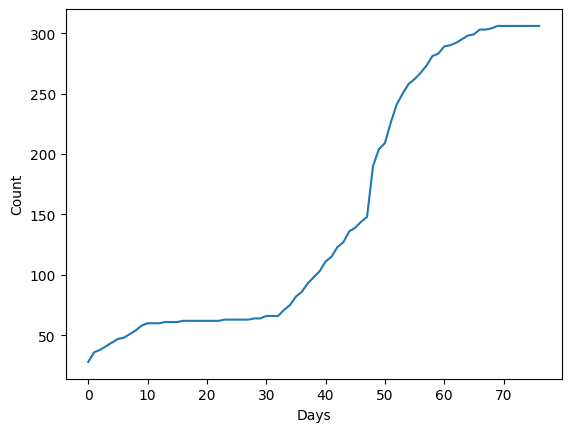

In [ ]:
plt.xlabel("Days")
plt.ylabel("Count")
plt.plot(sqlDF.toPandas()["count(ConfirmedCases)"])

<Axes: >

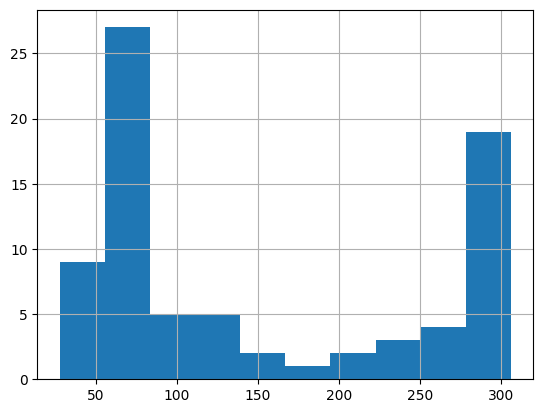

In [ ]:
sqlDF.toPandas()["count(ConfirmedCases)"].hist()

In [ ]:
sqlDF.toPandas()["count(ConfirmedCases)"].describe()

count     77.000000
mean     150.636364
std      104.538825
min       28.000000
25%       62.000000
50%       98.000000
75%      273.000000
max      306.000000
Name: count(ConfirmedCases), dtype: float64

**Per Day Fatalities Sorted**

In [ ]:
sqlDF = spark.sql("SELECT Date, count(Fatalities) FROM train_df WHERE Fatalities>0 GROUP BY Date ORDER BY Date ASC")
sqlDF.show()

+----------+-----------------+
|      Date|count(Fatalities)|
+----------+-----------------+
|2020-01-22|                1|
|2020-01-23|                2|
|2020-01-24|                3|
|2020-01-25|                3|
|2020-01-26|                5|
|2020-01-27|                7|
|2020-01-28|                7|
|2020-01-29|                8|
|2020-01-30|                8|
|2020-01-31|                8|
|2020-02-01|                9|
|2020-02-02|               10|
|2020-02-03|               10|
|2020-02-04|               11|
|2020-02-05|               13|
|2020-02-06|               13|
|2020-02-07|               15|
|2020-02-08|               17|
|2020-02-09|               20|
|2020-02-10|               21|
+----------+-----------------+
only showing top 20 rows



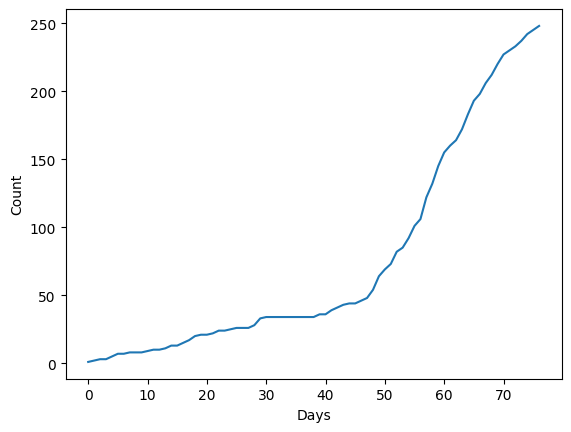

In [ ]:
plt.xlabel("Days")
plt.ylabel("Count")
plt.plot(sqlDF.toPandas()["count(Fatalities)"])

<Axes: >

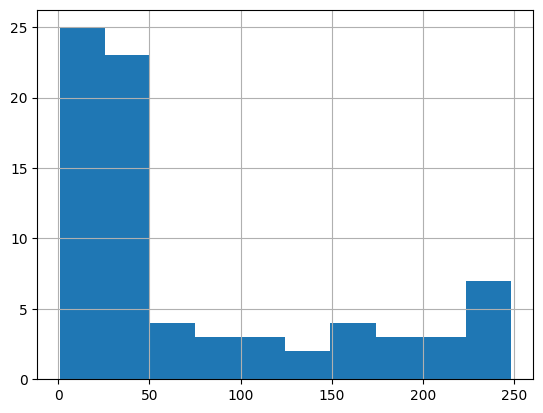

In [ ]:
sqlDF.toPandas()["count(Fatalities)"].hist()

In [ ]:
sqlDF.toPandas()["count(Fatalities)"].describe()

count     77.000000
mean      75.051948
std       78.030172
min        1.000000
25%       21.000000
50%       34.000000
75%      122.000000
max      248.000000
Name: count(Fatalities), dtype: float64

**Countrywise Confirmed Cases**

In [ ]:
sqlDF = spark.sql("SELECT Country_Region, count(ConfirmedCases) FROM train_df WHERE ConfirmedCases>0 GROUP BY Country_Region")
sqlDF.toPandas()["count(ConfirmedCases)"].describe()

count     180.000000
mean       64.438889
std       220.315623
min         8.000000
25%        24.000000
50%        33.000000
75%        42.000000
max      2522.000000
Name: count(ConfirmedCases), dtype: float64

In [ ]:
sqlDF = spark.sql("SELECT Country_Region, count(ConfirmedCases) FROM train_df WHERE ConfirmedCases>0 GROUP BY Country_Region ORDER BY count(ConfirmedCases) DESC LIMIT 5").show()

+--------------+---------------------+
|Country_Region|count(ConfirmedCases)|
+--------------+---------------------+
|         China|                 2522|
|            US|                 1517|
|     Australia|                  416|
|        Canada|                  394|
|        France|                  328|
+--------------+---------------------+



In [ ]:
sqlDF = spark.sql("SELECT Country_Region, count(ConfirmedCases) FROM train_df WHERE ConfirmedCases>0 GROUP BY Country_Region ORDER BY count(ConfirmedCases) ASC LIMIT 5").show()

+--------------+---------------------+
|Country_Region|count(ConfirmedCases)|
+--------------+---------------------+
|  Sierra Leone|                    8|
|       Burundi|                    8|
|      Botswana|                    9|
|    MS Zaandam|                   11|
|         Burma|                   12|
+--------------+---------------------+



**Countrywise Fatalities**

In [ ]:
sqlDF = spark.sql("SELECT Country_Region, count(Fatalities) FROM train_df WHERE Fatalities>0 GROUP BY Country_Region")
sqlDF.toPandas()["count(Fatalities)"].describe()

count     146.000000
mean       39.582192
std       158.831281
min         1.000000
25%        11.000000
50%        18.000000
75%        26.750000
max      1662.000000
Name: count(Fatalities), dtype: float64

In [ ]:
sqlDF = spark.sql("SELECT Country_Region, count(Fatalities) FROM train_df WHERE Fatalities>0 GROUP BY Country_Region ORDER BY count(Fatalities) DESC LIMIT 5").show()

+--------------+-----------------+
|Country_Region|count(Fatalities)|
+--------------+-----------------+
|         China|             1662|
|            US|             1003|
|        Canada|              122|
|     Australia|              117|
|        France|              110|
+--------------+-----------------+



In [ ]:
sqlDF = spark.sql("SELECT Country_Region, count(Fatalities) FROM train_df WHERE Fatalities>0 GROUP BY Country_Region ORDER BY count(Fatalities) ASC LIMIT 5").show()

+-------------------+-----------------+
|     Country_Region|count(Fatalities)|
+-------------------+-----------------+
|Antigua and Barbuda|                1|
|              Benin|                2|
|             Belize|                2|
|           Barbados|                3|
|           Ethiopia|                3|
+-------------------+-----------------+



#**Data Preprocessing**

**Removing NULL values**

In [ ]:
N_NULL_DF = spark.sql("SELECT * FROM train_df WHERE Province_State IS NOT NULL")

**Convert Timestamp to UnixTimestamp**

In [ ]:
indexer = StringIndexer(inputCol="Province_State", outputCol="Province_StateIndex")
indexed = indexer.fit(N_NULL_DF).transform(N_NULL_DF)
indexed.show()

+---+--------------------+--------------+----------+--------------+----------+-------------------+
| Id|      Province_State|Country_Region|      Date|ConfirmedCases|Fatalities|Province_StateIndex|
+---+--------------------+--------------+----------+--------------+----------+-------------------+
|857|Australian Capita...|     Australia|2020-01-22|           0.0|       0.0|                8.0|
|858|Australian Capita...|     Australia|2020-01-23|           0.0|       0.0|                8.0|
|859|Australian Capita...|     Australia|2020-01-24|           0.0|       0.0|                8.0|
|860|Australian Capita...|     Australia|2020-01-25|           0.0|       0.0|                8.0|
|861|Australian Capita...|     Australia|2020-01-26|           0.0|       0.0|                8.0|
|862|Australian Capita...|     Australia|2020-01-27|           0.0|       0.0|                8.0|
|863|Australian Capita...|     Australia|2020-01-28|           0.0|       0.0|                8.0|
|864|Austr

**Convert Categorical Attributes to Nominal**

In [ ]:
indexer = StringIndexer(inputCol="Province_State", outputCol="Province_StateIndex")
indexed = indexer.fit(N_NULL_DF).transform(N_NULL_DF)

indexer = StringIndexer(inputCol="Country_Region", outputCol="Country_RegionIndex")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="Date", outputCol="DateIndex")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="Fatalities", outputCol="FatalitiesIndex")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="ConfirmedCases", outputCol="ConfirmedCasesIndex")
indexed = indexer.fit(indexed).transform(indexed)

indexed.show(200)

+----+--------------------+--------------+----------+--------------+----------+-------------------+-------------------+---------+---------------+-------------------+
|  Id|      Province_State|Country_Region|      Date|ConfirmedCases|Fatalities|Province_StateIndex|Country_RegionIndex|DateIndex|FatalitiesIndex|ConfirmedCasesIndex|
+----+--------------------+--------------+----------+--------------+----------+-------------------+-------------------+---------+---------------+-------------------+
| 857|Australian Capita...|     Australia|2020-01-22|           0.0|       0.0|                8.0|                5.0|      0.0|            0.0|                0.0|
| 858|Australian Capita...|     Australia|2020-01-23|           0.0|       0.0|                8.0|                5.0|      1.0|            0.0|                0.0|
| 859|Australian Capita...|     Australia|2020-01-24|           0.0|       0.0|                8.0|                5.0|      2.0|            0.0|                0.0|
| 86

In [ ]:
test_df = spark.read.csv('/content/drive/MyDrive/testBD.csv',header = "true")

In [ ]:
test_df.show()

+---+--------------+--------------+----------+
| Id|Province_State|Country_Region|      Date|
+---+--------------+--------------+----------+
|  1|          null|   Afghanistan|26-03-2020|
|  2|          null|   Afghanistan|27-03-2020|
|  3|          null|   Afghanistan|28-03-2020|
|  4|          null|   Afghanistan|29-03-2020|
|  5|          null|   Afghanistan|30-03-2020|
|  6|          null|   Afghanistan|31-03-2020|
|  7|          null|   Afghanistan|01-04-2020|
|  8|          null|   Afghanistan|02-04-2020|
|  9|          null|   Afghanistan|03-04-2020|
| 10|          null|   Afghanistan|04-04-2020|
| 11|          null|   Afghanistan|05-04-2020|
| 12|          null|   Afghanistan|06-04-2020|
| 13|          null|   Afghanistan|07-04-2020|
| 14|          null|   Afghanistan|08-04-2020|
| 15|          null|   Afghanistan|09-04-2020|
| 16|          null|   Afghanistan|10-04-2020|
| 17|          null|   Afghanistan|11-04-2020|
| 18|          null|   Afghanistan|12-04-2020|
| 19|        

In [ ]:
test_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Province_State: string (nullable = true)
 |-- Country_Region: string (nullable = true)
 |-- Date: string (nullable = true)



In [ ]:
test_df.createOrReplaceTempView("test_df")
sqlDF = spark.sql("SELECT Country_Region FROM test_df GROUP BY Country_Region")
print("Total Countries: ",len(sqlDF.toPandas()["Country_Region"]))
sqlDF = spark.sql("SELECT Date FROM test_df GROUP BY Date")
print("Total Days: ",len(sqlDF.toPandas()['Date']))

Total Countries:  180
Total Days:  43


In [ ]:
N = spark.sql("SELECT * FROM test_df WHERE Province_State IS NOT NULL")

In [ ]:
indexer1 = StringIndexer(inputCol="Province_State", outputCol="Province_StateIndex")
indexed1 = indexer1.fit(N).transform(N)

indexer1 = StringIndexer(inputCol="Country_Region", outputCol="Country_RegionIndex")
indexed1 = indexer1.fit(indexed1).transform(indexed1)

indexer1 = StringIndexer(inputCol="Date", outputCol="DateIndex")
indexed1 = indexer1.fit(indexed1).transform(indexed1)

indexed1.show(20)

+---+--------------------+--------------+----------+-------------------+-------------------+---------+
| Id|      Province_State|Country_Region|      Date|Province_StateIndex|Country_RegionIndex|DateIndex|
+---+--------------------+--------------+----------+-------------------+-------------------+---------+
|345|Australian Capita...|     Australia|26-03-2020|                8.0|                5.0|     32.0|
|346|Australian Capita...|     Australia|27-03-2020|                8.0|                5.0|     34.0|
|347|Australian Capita...|     Australia|28-03-2020|                8.0|                5.0|     36.0|
|348|Australian Capita...|     Australia|29-03-2020|                8.0|                5.0|     38.0|
|349|Australian Capita...|     Australia|30-03-2020|                8.0|                5.0|     40.0|
|350|Australian Capita...|     Australia|31-03-2020|                8.0|                5.0|     42.0|
|351|Australian Capita...|     Australia|01-04-2020|                8.0| 

In [ ]:
assembler = VectorAssembler(inputCols=['Province_StateIndex', 'Country_RegionIndex', 'DateIndex'],outputCol="features")
test_df = assembler.transform(indexed1)

#**Model Buliding**

##Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
# Create a vector representation for features
assembler = VectorAssembler(inputCols=['Province_StateIndex', 'Country_RegionIndex', 'DateIndex'],outputCol="features")
train_df = assembler.transform(indexed)
# Fit a linear regression model
lr = LinearRegression(featuresCol = 'features', labelCol='FatalitiesIndex', maxIter=100, tol=1e-6, fitIntercept=False,standardization=True, solver="auto", aggregationDepth=2,loss="huber", epsilon=1.35)
lr_model = lr.fit(train_df)
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))
# Summarize the model over the training set and print out some metrics
trainingSummary = lr_model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
#trainingSummary.residuals.show()
print("RMSE: %f" % (trainingSummary.rootMeanSquaredError/100))
print("MAE: %f" % (trainingSummary.meanAbsoluteError/10))
print("MSE: %f" % (trainingSummary.meanSquaredError/1000))
#print("r2: %f" % trainingSummary.r2)

Coefficients: [-0.0019048623030269711,-0.07545287913233832,0.016986813520966967]
Intercept: 0.0
numIterations: 13
objectiveHistory: [10.419794452123877, 7.789609581022426, 7.6504149450104055, 7.534878449447834, 7.520705601723091, 7.516836799129104, 7.506049814132804, 7.499881070584768, 7.498287698407709, 7.498127119382976, 7.498118358840881, 7.498117849216002, 7.498117772862004, 7.498117772620634]
RMSE: 0.263123
MAE: 0.561318
MSE: 0.692339


In [ ]:
confirmedcases_lr_predictions = lr_model.transform(test_df)

In [ ]:
confirmedcases_lr_predictions.show()

+---+--------------------+--------------+----------+-------------------+-------------------+---------+--------------+--------------------+
| Id|      Province_State|Country_Region|      Date|Province_StateIndex|Country_RegionIndex|DateIndex|      features|          prediction|
+---+--------------------+--------------+----------+-------------------+-------------------+---------+--------------+--------------------+
|345|Australian Capita...|     Australia|26-03-2020|                8.0|                5.0|     32.0|[8.0,5.0,32.0]| 0.15107473858503556|
|346|Australian Capita...|     Australia|27-03-2020|                8.0|                5.0|     34.0|[8.0,5.0,34.0]| 0.18504836562696952|
|347|Australian Capita...|     Australia|28-03-2020|                8.0|                5.0|     36.0|[8.0,5.0,36.0]|  0.2190219926689035|
|348|Australian Capita...|     Australia|29-03-2020|                8.0|                5.0|     38.0|[8.0,5.0,38.0]| 0.25299561971083734|
|349|Australian Capita...| 

##Decision Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
# Create a vector representation for features
assembler = VectorAssembler(inputCols=['Country_RegionIndex', 'DateIndex'],outputCol="features")
train_df = assembler.transform(indexed)
# Fit a linear regression model
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='ConfirmedCasesIndex', maxDepth = 3, maxBins=1000)
dt_model = dt.fit(train_df)

In [ ]:
confirmedcases_dt_predictions = dt_model.transform(test_df)

In [ ]:
confirmedcases_dt_predictions.show()

+---+--------------------+--------------+----------+-------------------+-------------------+---------+--------------+-----------------+
| Id|      Province_State|Country_Region|      Date|Province_StateIndex|Country_RegionIndex|DateIndex|      features|       prediction|
+---+--------------------+--------------+----------+-------------------+-------------------+---------+--------------+-----------------+
|345|Australian Capita...|     Australia|26-03-2020|                8.0|                5.0|     32.0|[8.0,5.0,32.0]|4.049255441008018|
|346|Australian Capita...|     Australia|27-03-2020|                8.0|                5.0|     34.0|[8.0,5.0,34.0]|4.049255441008018|
|347|Australian Capita...|     Australia|28-03-2020|                8.0|                5.0|     36.0|[8.0,5.0,36.0]|4.049255441008018|
|348|Australian Capita...|     Australia|29-03-2020|                8.0|                5.0|     38.0|[8.0,5.0,38.0]|4.049255441008018|
|349|Australian Capita...|     Australia|30-03-2

##Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
# Create a vector representation for features
assembler = VectorAssembler(inputCols=['Country_RegionIndex', 'DateIndex'],outputCol="features")
train_df = assembler.transform(indexed)
# Fit a linear regression model
rf = RandomForestRegressor(featuresCol = 'features', labelCol='FatalitiesIndex', maxDepth = 3, maxBins=1000)
rf_model = rf.fit(train_df)

In [ ]:
# Create a vector representation for features
assembler = VectorAssembler(inputCols=['Country_RegionIndex', 'DateIndex'],outputCol="features")
test_df = assembler.transform(indexed1)
fatalities_rf_predictions = rf_model.transform(test_df)

In [ ]:
fatalities_rf_predictions.show()

+---+--------------------+--------------+----------+-------------------+-------------------+---------+----------+------------------+
| Id|      Province_State|Country_Region|      Date|Province_StateIndex|Country_RegionIndex|DateIndex|  features|        prediction|
+---+--------------------+--------------+----------+-------------------+-------------------+---------+----------+------------------+
|345|Australian Capita...|     Australia|26-03-2020|                8.0|                5.0|     32.0|[5.0,32.0]|0.2947653569141212|
|346|Australian Capita...|     Australia|27-03-2020|                8.0|                5.0|     34.0|[5.0,34.0]| 0.530347211949252|
|347|Australian Capita...|     Australia|28-03-2020|                8.0|                5.0|     36.0|[5.0,36.0]|0.5901710610074955|
|348|Australian Capita...|     Australia|29-03-2020|                8.0|                5.0|     38.0|[5.0,38.0]|0.2947653569141212|
|349|Australian Capita...|     Australia|30-03-2020|                8

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

##Gradient Boosted Tree

In [ ]:
from pyspark.ml.regression import GBTRegressor

In [ ]:
# Create a vector representation for features
assembler = VectorAssembler(inputCols=['Country_RegionIndex', 'DateIndex'],outputCol="features")
train_df = assembler.transform(indexed)
# Fit a linear regression model
rf = GBTRegressor(featuresCol = 'features', labelCol='ConfirmedCasesIndex', maxDepth = 3, maxBins=1000)
rf_model = rf.fit(train_df)

In [ ]:
# Create a vector representation for features
assembler = VectorAssembler(inputCols=['Country_RegionIndex', 'DateIndex'],outputCol="features")
test_df = assembler.transform(indexed1)
fatalities_rf_predictions = rf_model.transform(test_df)

In [ ]:
fatalities_rf_predictions.show()

+---+--------------------+--------------+----------+-------------------+-------------------+---------+----------+-------------------+
| Id|      Province_State|Country_Region|      Date|Province_StateIndex|Country_RegionIndex|DateIndex|  features|         prediction|
+---+--------------------+--------------+----------+-------------------+-------------------+---------+----------+-------------------+
|345|Australian Capita...|     Australia|26-03-2020|                8.0|                5.0|     32.0|[5.0,32.0]| 14.528497682115308|
|346|Australian Capita...|     Australia|27-03-2020|                8.0|                5.0|     34.0|[5.0,34.0]| 13.117149399392355|
|347|Australian Capita...|     Australia|28-03-2020|                8.0|                5.0|     36.0|[5.0,36.0]|  5.966011784082064|
|348|Australian Capita...|     Australia|29-03-2020|                8.0|                5.0|     38.0|[5.0,38.0]| 0.8250284125909986|
|349|Australian Capita...|     Australia|30-03-2020|          